Today I'll be going over how to pull log curve data from a SeisWare project and apply a few different clustering algorithms available in scikit-learn.

This is going to involve using the SeisWare SDK, and all the code is going to be done in Python.

The first thing I'll do is import SeisWare and another library. All of the code you're seeing today will be available on this github repo

 https://github.com/markogauk/Clustering_Webinar

Here's what I'll be going over:
    
    1. Connecting to a SeisWare project
    2. Getting a well object
    3. Getting the log curves from that well into a DataFrame
    4. Plot the logs in a simple plot
    5. Survey the data with a pair plot
    6. Run through multiple different clustering algorithms with the data and show the results
    7. Choose a single algorithm and return a curve containing the clusters as a curve
    8. Bring that curve back into SeisWare and display the clusters
    
 I'll also talk about how steps 1-3 can be replaced for a generic LAS file, and how to output a new LAS file containing the cluster values.

In [1]:
import SeisWare
import SWconnect


import SeisWare brings in the main SeisWare SDK library. To save time and to help simplify things, I've also included some functions from the SWconnect file. This way I don't have to waste time repeating some of the same operations.

First I'm going to load my project and define my depth units.

In [2]:
login_instance = SWconnect.SWconnect("TeaPot-Demoset")
depth_unit = SeisWare.Unit.Foot

Now that I've got my login instance of the project, lets take a look at a well

In [3]:
well = SWconnect.getWell("490250634800",login_instance)
print(well.UWI())

490250634800


In [4]:
def get_log_curve_names(well,login_instance):
    '''
    Return all the names of log curves for a given well
    
    well: SeisWare Well Object
    
    login_instance: SeisWare login instance to project
    
    Returns: List of log curves belonging to the well
    
    '''
    log_curve_list = SeisWare.LogCurveList()
    
    login_instance.LogCurveManager().GetAllForWell(well.ID(), log_curve_list)
    
    log_curves = [log_curve.Name() for log_curve in log_curve_list]
    
    
    
    return log_curves

I'm going to be using a handy library called pandas to organize my data

In [5]:
import pandas as pd

Now that I've got a well, lets get some log curve data. Log curves in SeisWare always have regular step rates once loaded into SeisWare. I'm going to get every log curve for a given well in the project. We can define a function **get_all_log_curves** 

Lets retrieve all of the log curves from a well and put it into a dataframe

In [6]:
import time

def log_value_fill(log_curve):
    '''
    Take a log curve object and return a dataframe containing the depths and curve values
    '''
    
    login_instance.LogCurveManager().PopulateValues(log_curve)
    
    log_curve_values = SeisWare.DoublesList()
    
    log_curve.Values(log_curve_values)
    
    log_list = []
    
    
    for i,values in enumerate(log_curve_values):
        log_list.append(((log_curve.TopDepth()+log_curve.DepthInc()*i).Value(depth_unit),values))     

  
    #Return a dataframe indexed on MD with the corresponding value
    
    return pd.DataFrame(log_list,columns = ['DEPT',log_curve.Name()]).set_index('DEPT')

def get_all_log_curves(well,login_instance):
    '''
    Given the well name and login instance, return a dataframe containing all log curves
    
    well: SeisWare Well Object
    
    login_instance: SeisWare login instance to project
    
    Returns: Dataframe containing all log data from a given well, indexed on Depth
    
    '''

    log_curve_list = SeisWare.LogCurveList()

    login_instance.LogCurveManager().GetAllForWell(well.ID(), log_curve_list)

    #Concatenate list of DataFrames to create table of all curves on well
    
    log_dfs = pd.concat([log_value_fill(i) for i in log_curve_list],axis=1)
    
    return log_dfs
    

In [7]:
import lasio



In [8]:
import numpy as np

import matplotlib.colors as mcol

import matplotlib.pyplot as plt

# Set a consistent colormap for use in all plots
ccc = ['b','g','r','c','m','y','k','#B3B3B3','#996633',]
cmap_facies = mcol.ListedColormap(ccc[0:len(ccc)], 'indexed')

def logs_plot(UWI,data,top_depth,bottom_depth):
    
    logs=data[(data.index >= top_depth) & (data.index <= bottom_depth)]
    fig, ax = plt.subplots(nrows=1, ncols=len(data.columns), figsize=(12,10), sharey=True)
    fig.suptitle(f"Log Curves for Well:{UWI}", fontsize=22)
    
    colors = np.array(ccc)
    colors = np.hstack([colors] * 20)
    
# General setting for all axis

# Plot most curves the same. If a well has a log curve named clusters, plot it as an image.
    for i,axes in enumerate(ax):
        axes.yaxis.grid(True)
        if data.columns[i] == 'Clusters':
            cluster=np.repeat(np.expand_dims(logs['Clusters'].values,1), 100, 1)
            axes.imshow(np.expand_dims(logs['Clusters'],1), interpolation='none',cmap=cmap_facies, aspect='auto',
                        extent=(0,8,bottom_depth,top_depth),vmin=0,vmax=8)  
        elif data.columns[i] == 'Spectral':
            cluster=np.repeat(np.expand_dims(logs['Spectral'].values,1), 100, 1)
            axes.imshow(np.expand_dims(logs['Spectral'],1), interpolation='none',cmap=cmap_facies, aspect='auto',
                        extent=(0,8,bottom_depth,top_depth),vmin=0,vmax=8)  
        else:
            axes.plot(data.iloc[:,i], logs.index, label=f'{data.columns[i]}', color='blue')
        axes.set_ylim(top_depth,bottom_depth)
        axes.invert_yaxis()
        axes.set_xlabel(data.columns[i])    
        axes.label_outer()



Using the functions created above, in a few lines we can connect to a project, get a single well object, get the data from that well object, and plot the curves.

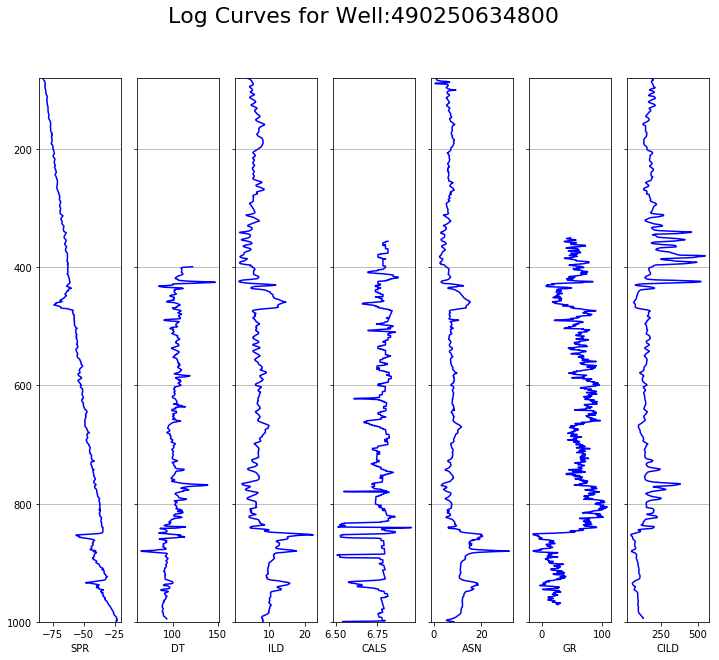

In [22]:
useSDK = True


if useSDK == True:
    login_instance = SWconnect.SWconnect("TeaPot-Demoset")

    depth_unit = SeisWare.Unit.Foot

    UWI = "490250634800"
    
    well = SWconnect.getWell(UWI,login_instance)

    data = get_all_log_curves(well,login_instance)

else:
    import lasio

    las = lasio.read(r'D:\Seismic\TeaPot-Demoset\490250634800.las')

    data = las.df()
    UWI = las.well.UWI.value

logs_plot(UWI,data,data.index.min(),data.index.max())


Let's look at some stats from the data, using the describe function in **Pandas**

In [23]:
data.describe()

,SPR,DT,ILD,CALS,ASN,GR,CILD
count,1841.000000,1193.000000,1841.000000,1289.000000,1841.000000,1243.000000,1829.000000
mean,-55.500935,100.970956,7.261565,6.771646,8.096883,55.329483,161.301516
std,15.245580,7.987604,2.729118,0.058376,3.424120,25.993619,68.383744
min,-82.728200,65.151900,1.630300,6.508900,0.439500,-14.652600,48.265500
25%,-68.821700,94.898000,5.596800,6.755100,6.201000,35.951650,128.535800
50%,-55.141600,101.611400,6.772500,6.784300,7.334500,61.468400,152.845400
75%,-42.347200,105.637700,8.234500,6.800300,8.707600,73.916700,183.706600
max,-22.850400,147.171300,22.336500,6.955100,31.810400,108.308200,548.584200


The values in my curves are currently all over the place, so I'm going to need to do some normalization before running my clustering. Sci-kit 

In [24]:

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler


https://scikit-learn.org/stable/modules/clustering.html

In [25]:
import sys

In [26]:

import matplotlib.colors as mcol

def plot_clusters(logX,logY,n_clusters):

    df = data[[logX,logY]].dropna()

    X = StandardScaler().fit_transform(df)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # create clustering estimators
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=n_clusters)
    ward = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='ward',
                                           connectivity=connectivity)
    spectral = cluster.SpectralClustering(n_clusters=n_clusters,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=.12)
    affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                       preference=-200)

    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",affinity="l1", n_clusters=n_clusters,
        connectivity=connectivity)

    birch = cluster.Birch(n_clusters=n_clusters)
    clustering_algorithms = [
        two_means, affinity_propagation, ms, spectral, ward, average_linkage,
        dbscan, birch]

    clustering_names = [
        'MiniBatchKMeans', 'AffinityPropagation', 'MeanShift',
        'SpectralClustering', 'Ward', 'AgglomerativeClustering',
        'DBSCAN', 'Birch']
    plot_num = 1

    colors = np.array(['b','g','r','c','m','y','k','#B3B3B3','#996633',]*2)
    #colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
    #colors = np.hstack([colors] * 20)
    ccc = ['b','g','r','c','m','y','k','#B3B3B3','#996633',]
    cmap_facies = mcol.ListedColormap(colors[0:len(colors)], 'indexed')

    
    plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                        hspace=.01)

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        plt.subplot(4, len(clustering_algorithms), plot_num)
        
        plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)
        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xticks(())
        plt.yticks(())
        plt.xlabel(df.columns[0])
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1


    
    plt.show()
    
    return

In [27]:
from ipywidgets import interactive

In [28]:
%matplotlib inline

interactive_plot = interactive(plot_clusters,
                               logX=data.columns,
                               logY=data.columns,
                               n_clusters = range(1,9))


In [29]:
interactive_plot

interactive(children=(Dropdown(description='logX', options=('SPR', 'DT', 'ILD', 'CALS', 'ASN', 'GR', 'CILD'), …

Lets take a look at a single algorithm. K means.

First we'll retrieve the two log curves and merge them on MD.

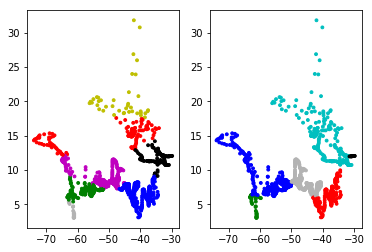

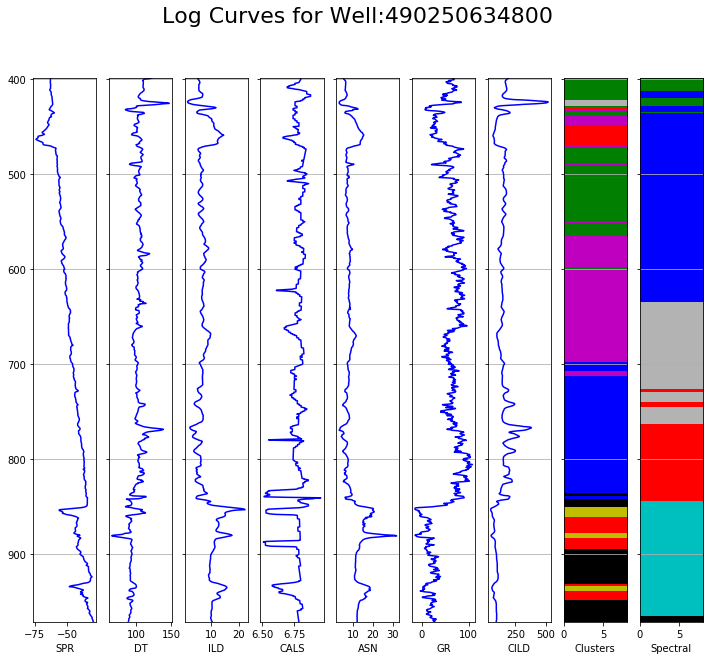

In [30]:
logX = "SPR"

logY = "ASN"
n_clusters = 8


df = data[[logX,logY]].dropna().reset_index()

#Scale data and put it back in a dataframe

X = pd.DataFrame(StandardScaler().fit_transform(df.iloc[:,:]))

#Add column names back to newly scaled dataframe

X.columns = df.columns[:]

#Create the K-means

two_means = cluster.MiniBatchKMeans(n_clusters=n_clusters, n_init=10, max_no_improvement=10,batch_size=45,)

spectral = cluster.SpectralClustering(n_clusters=n_clusters,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")

# Fit the clusters using both Spectral Clustering and Mini Batch Kmeans to compare

spectral.fit(X[[logX,logY]])

two_means.fit(X[[logX,logY]])

y_pred = two_means.labels_.astype(np.int)

y_pred_spectral = spectral.labels_.astype(np.int)

df["Clusters"] = pd.Series(y_pred)

df["Spectral"] = pd.Series(y_pred_spectral)

df = df.set_index("DEPT")

data['Clusters'] = df['Clusters']
data['Spectral'] = df['Spectral']

colors = np.array(['b','g','r','c','m','y','k','#B3B3B3','#996633',])

data.dropna(inplace=True)

plt.subplot(1,2,1)
plt.scatter(data[logX], data[logY], color=colors[data['Clusters'].astype(np.int)].tolist(), s=8)
plt.subplot(1,2,2)
plt.scatter(data[logX], data[logY], color=colors[data['Spectral'].astype(np.int)].tolist(), s=8)


logs_plot(UWI,data,data.index.min(),data.index.max())


In [31]:
#seabornPalette = sns.color_palette(ccc[0:len(ccc)])

#p = sns.pairplot(data.dropna(), hue = 'clusters', palette = seabornPalette,plot_kws={"s": 18})


In [38]:
def clusters_to_SW(well,curve,login_instance):
    
    ### Takes in well by UWI, curve data from dataframe as a list and login instance of project
    
    wellObj = SWconnect.getWell(well,login_instance)
    
    newCurve = SeisWare.LogCurve()

    newCurve.SetValues(curve)

    newCurve.ParentID(wellObj.ID())

    newCurve.Name("Clusters")

    newCurve.NullValue(-999.25)
    newCurve.DepthInc(SeisWare.Measurement(0.5,depth_unit))

    newCurve.TopDepth(SeisWare.Measurement(df.index.min(),depth_unit))
    newCurve.BaseDepth(SeisWare.Measurement(df.index.max(),depth_unit))

    # Get the list of curves in the well to check if curve exists
    
    log_curve_list = SeisWare.LogCurveList()
    login_instance.LogCurveManager().GetAllForWell(wellObj.ID(), log_curve_list)

    if newCurve.Name() not in [i.Name() for i in log_curve_list]:
        login_instance.LogCurveManager().Add(newCurve)
    else:
        newCurve = [i for i in log_curve_list if i.Name()=="Clusters"]
        login_instance.LogCurveManager().Update(newCurve[0])
    
    return 

Now we can run the function to output the curve to the desired UWI based on the login instance.

In [39]:

if useSDK == True:
    clusters_to_SW(UWI,df.Clusters.tolist(),login_instance)
    
    
else:
    import lasio
    las = lasio.read(r'D:\Seismic\TeaPot-Demoset\490250634800.las')

    las.set_data(data)
    UWI = las.well.UWI.value
    
    las.write("clusters.las")

In [37]:
UWI = '490251039200'

In [38]:
d2 = get_all_log_curves(SWconnect.getWell(UWI,login_instance),login_instance)

<IPython.core.display.Javascript object>


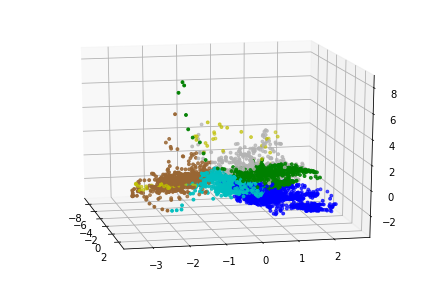

In [53]:


logX = "RHOB"

logY = "NPHI"

logZ = "GRD"

n_clusters = 6

from mpl_toolkits.mplot3d import Axes3D

df = d2[[logX,logY,logZ]].dropna().reset_index()

#Scale data and put it back in a dataframe

X = pd.DataFrame(StandardScaler().fit_transform(df.iloc[:,:]))

#Add column names back to newly scaled dataframe

X.columns = df.columns[:]

#Create the K-means

two_means = cluster.MiniBatchKMeans(n_clusters=n_clusters)

two_means.fit(X[[logX,logY,logZ]])

y_pred = two_means.labels_


df["Clusters"] = pd.Series(y_pred)

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X[logX],X[logY],X[logZ],c=df["Clusters"],cmap = cmap_facies,s=8)

#print(df)

df = df.set_index("DEPT")




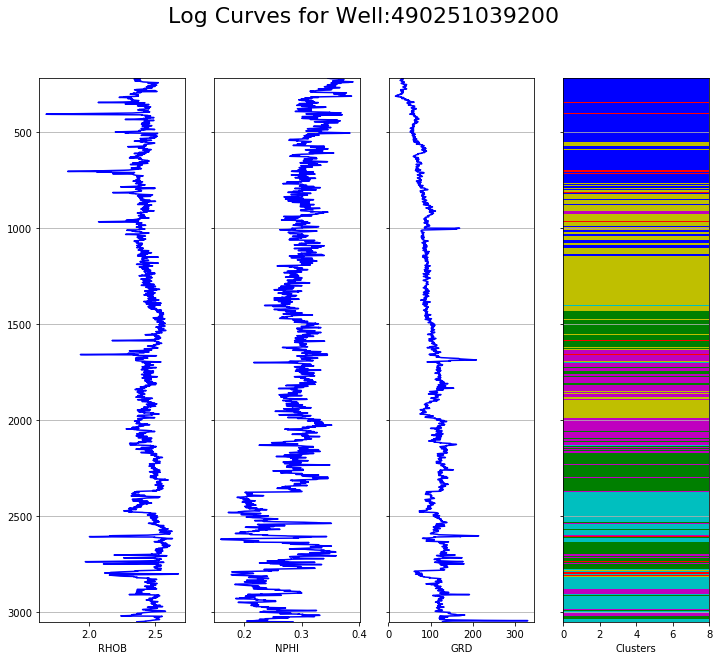

In [45]:

logs_plot(UWI,df,df.index.min(),df.index.max())


Now we can output the newly generated cluster curve to SeisWare


In [ ]:

clusters_to_SW(UWI,df.clusters.tolist(),login_instance)
    
    
